### Description

This notebook loads the data csv file and plots Figures 3 (right panel) and A4. Minor post-processing was done after the fact to compile and format the figures.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
csv_file = "data/deep-nonlinear.csv"
df = pd.read_csv(csv_file).set_index("id")

In [3]:
metric = "validation-1/loss"
names = ["single_task", "main_train_pts", "nlayers", "s_a", "train_seed"]
new_index = pd.MultiIndex.from_tuples([tuple(x) for x in df[names].values], names=names)
df_single = df[metric].set_axis(new_index, axis=0, inplace=False).sort_index()[True]

names = ["single_task", "main_train_pts", "nlayers", "s_a", "s_b", "relatedness", "train_seed"]
new_index = pd.MultiIndex.from_tuples([tuple(x) for x in df[names].values], names=names)
df_multi = df[metric].set_axis(new_index, axis=0, inplace=False).sort_index()[False]

In [4]:
def benefit_generalized(df1, df2):
    df = df1.sub(df2, axis="index")

    return pd.DataFrame(df).T.reorder_levels(df2.index.names, axis=1).sort_index(axis=1)

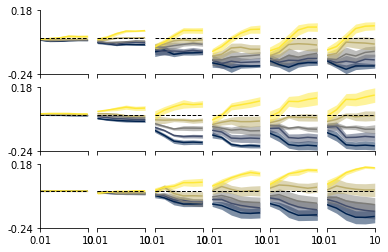

In [5]:
ntrain = 800
tmp = benefit_generalized(df_single, df_multi)[ntrain]
data = tmp.stack().droplevel(0)
n = len(data)
mean = data.mean().unstack(2).T
err = data.std().unstack(2).T /  n ** .5
ncolors = len(mean.columns.levels[2])
cmap = plt.cm.cividis(np.linspace(0, 1, ncolors))[:, :3]
fig, axs = plt.subplots(len(mean.columns.levels[0]), len(mean.columns.levels[1]))
a = len(mean.columns.levels[0]) / len(mean.columns.levels[1])
#fig.set_size_inches([5.5, 5.5 * a])
miny = np.round((mean - err).values.min(), 2)
miny = -.1 if miny >= -.1 else miny
maxy = np.round((mean + err).values.max(), 2)
minx = mean.index.values.min()
maxx = mean.index.values.max()
maxx = int(maxx) if maxx > 1 else maxx
for nn, nlayers in enumerate(mean.columns.levels[0]):
    for ii, s1 in enumerate(mean.columns.levels[1]):
        ax = axs[nn, ii]
        for jj, re in enumerate(mean.columns.levels[2]):
            ax.plot(mean.index.values, mean[nlayers][s1][re], color=cmap[jj], label="{:1.2f}".format(re), solid_capstyle="butt")        
            ax.fill_between(mean.index.values, mean[nlayers][s1][re] - err[nlayers][s1][re], mean[nlayers][s1][re] + err[nlayers][s1][re], color=cmap[jj], alpha=0.5, edgecolor="none", lw=0)        
        ax.plot(mean.index.values, np.zeros_like(mean.index.values), color='k', linestyle='--', linewidth=1)
        for key, sp in ax.spines.items():
            if key in ("top", "right"):
                sp.set_visible(False)
            if ii > 0 and key == "left":
                sp.set_visible(False)
        
        ax.set_xlim([minx, maxx])
        ax.set_xscale('log')        
        ax.xaxis.set_ticks([minx, maxx])
        ax.xaxis.set_ticklabels([])        
        ax.xaxis.set_tick_params(direction="out", labelsize=10)
        ax.set_ylim([miny, maxy])
        #ax.set_ylabel("Multitask Benefit", fontsize=10)
        ax.yaxis.set_ticks([miny, maxy])
        ax.yaxis.set_ticklabels([])
        ax.yaxis.set_tick_params(direction="out", labelsize=10)
        
        if ii > 0:
            ax.yaxis.set_tick_params(size=0)
        
        if ii == 0:
            ax.yaxis.set_ticklabels([miny, maxy])
        if nn == (len(mean.columns.levels[0]) - 1):
            ax.xaxis.set_ticklabels([minx, maxx])

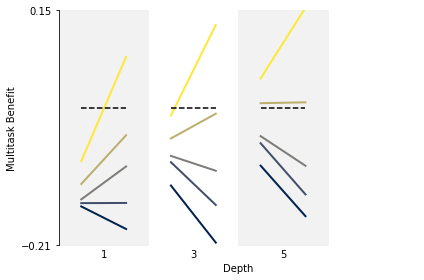

In [6]:
s1 = 10
d = mean.stack((0, -1))[s1].unstack((1, 2)).iloc[[0, -1]]
ncolors = len(d.columns.levels[1])
cmap = plt.cm.cividis(np.linspace(0, 1, ncolors))[:, :3]
fig, ax = plt.subplots(1, 1)
#fig.set_size_inches([3.5, 2])
w = .25
miny = np.round(d.values.min(), 2)
maxy = np.round(d.values.max(), 2)
minx = -.5
maxx = len(d.columns.levels[0]) + .5
for nn, nlayers in enumerate(d.columns.levels[0]):
    ax.fill_betweenx([miny, maxy], nn - .5, nn + .5, color=((1, 1, 1) if nn%2 else (.95, .95, .95)))
    for jj, re in enumerate(d.columns.levels[1]):
        ax.plot([nn - w, nn + w], [d[nlayers][re].iat[0], d[nlayers][re].iat[-1]], color=cmap[jj], linewidth=2)
    ax.plot([nn - w, nn + w], [0, 0], color='k', linestyle='--')
for key, sp in ax.spines.items():
    if key in ("top", "right", "bottom"):
        sp.set_visible(False)
ax.set_xlim([minx, maxx])
ax.xaxis.set_ticks(range(len(d.columns.levels[0])))
ax.xaxis.set_ticklabels(d.columns.levels[0])
ax.xaxis.set_tick_params(length=0, labelsize=10)
ax.set_xlabel("Depth", fontsize=10)
ax.set_ylim([miny, maxy])
ax.set_ylabel("Multitask Benefit", fontsize=10)
ax.yaxis.set_ticks([miny, maxy])
ax.yaxis.set_tick_params(direction="out", labelsize=10)
plt.tight_layout()